In [15]:
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import scipy as scipy
from scipy import optimize
import matplotlib.ticker as ticker
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
import nmrglue as ng
import os
import os.path
import sys
import pandas as pd
%matplotlib inline

In [16]:
#def  Lorenzen function
def _1Lorentzian(x, amp, cen, wid):
    return amp*wid**2/((x-cen)**2+wid**2)

def _2Lorentzian(x, amp1, cen1, wid1, amp2,cen2,wid2):
    return (amp1*wid1**2/((x-cen1)**2+wid1**2)) +\
            (amp2*wid2**2/((x-cen2)**2+wid2**2))

def Lorentz_fit(ddir, max_ppm, min_ppm, inital_val, num_peak=1):
    # import data in nmrpipe format
    dic,data = ng.pipe.read(ddir)

    # generate the ppm/ Hz scale for the data
    udic=ng.pipe.guess_udic(dic,data)
    uc = ng.fileiobase.uc_from_udic(udic)
    
    #generate region for fitting
    ppm_a=uc.ppm_scale()
    data2=data[uc(max_ppm, 'ppm'): uc(min_ppm,'ppm')]
    ppm2=ppm_a[uc(max_ppm, 'ppm'): uc(min_ppm,'ppm')]
    
    #get the folder name; need be informative about the data
    dir_name=os.path.dirname(ddir)
    title=dir_name.split('/')[-1]
    
    # fitting with one Lorentz peak
    if num_peak ==1:
        amp1 = inital_val[0]
        wid1 = inital_val[1]
        cen1 = inital_val[2]
        popt_lorentz, pcov_lorentz = scipy.optimize.curve_fit(_1Lorentzian, ppm2, data2, p0=[amp1, cen1, wid1])
        perr_lorentz = np.sqrt(np.diag(pcov_lorentz))
        lorentz_peak = _1Lorentzian(ppm2, *popt_lorentz)
        # output fitting results
        print ('This is the fitting result for {}'.format(dir_name))
        print ("---------fitting_region {} to {}------------".format(min_ppm, max_ppm))
        print ("-------------Peak-------------")
        print ('amplitude = {:0.2f} (+/-) {:0.2f}'.format(popt_lorentz[0], perr_lorentz[0]))
        print ("center = {:0.2f} (+/-) {:0.2f}" .format(popt_lorentz[1], perr_lorentz[1]))
        print ("peakwidth = {:0.2f} (+/-) {:0.2f}" .format(popt_lorentz[2], perr_lorentz[2]))
        print ("area = {:0.2f}".format( np.trapz(lorentz_peak)))
        print ("--------------------------------")
        
        
        with open("Lorentz_fit_{}.out".format(title), 'a') as f:
            f.write('This is the fitting result for {}'.format(dir_name)+'\n')
            f.write ("---------fitting_region {} to {}------------".format(min_ppm, max_ppm)+'\n')
            f.write ("-------------Peak-------------")
            f.write ('amplitude = {:0.2f} (+/-) {:0.2f}'.format(popt_lorentz[0], perr_lorentz[0])+'\n')
            f.write("center = {:0.2f} (+/-) {:0.2f}" .format(popt_lorentz[1], perr_lorentz[1])+'\n')
            f.write ("peakwidth = {:0.2f} (+/-) {:0.2f}" .format(popt_lorentz[2], perr_lorentz[2])+'\n')
            f.write ("area = {:0.2f}".format( np.trapz(lorentz_peak))+'\n')
            f.write ("--------------------------------"+'\n')
            
     #make a figure for the fitting
        fig = plt.figure(figsize=(4,3))
        gs = gridspec.GridSpec(2,1,height_ratios=[1,0.25] )
        ax1 = fig.add_subplot(gs[0])
        ax2  =fig.add_subplot(gs[1])
        gs.update(hspace=0)

        ax1.plot(ppm2, data2, "r-")
        ax1.plot(ppm2, _1Lorentzian(ppm2, *popt_lorentz), 'k--')

        ax2.plot(ppm2,data2-_1Lorentzian(ppm2, *popt_lorentz), 'ro', markersize=3 )

        # # peak 1
        
        ax1.fill_between(ppm2, lorentz_peak.min(), lorentz_peak, facecolor="green", alpha=0.5)

        #ax1.xaxis.set_major_locator(ticker.AutoLocator())
        #ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax2.xaxis.set_major_locator(ticker.AutoLocator())
        ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())

        ax1.set_xlim(max_ppm, min_ppm)
        ax2.set_xlim(max_ppm, min_ppm)

        fig.tight_layout()
        fig.savefig("Lorentz_fit_{} {} to {}reduced.png".format(title,max_ppm, min_ppm), format="png",dpi=1000)
        
        #return popt_lorentz + perr_lorentz
        return np.concatenate((popt_lorentz,perr_lorentz),axis=0)
            
    elif num_peak ==2:
        amp1 = inital_val[0]
        wid1 = inital_val[1]
        cen1 = inital_val[2]
        amp2 = inital_val[3]
        wid2 = inital_val[4]
        cen2 = inital_val[5]
        popt_2lorentz, pcov_2lorentz = scipy.optimize.curve_fit(_2Lorentzian, ppm2, data2, p0=[amp1, cen1, wid1, \
                                                                                    amp2, cen2, wid2])

        perr_2lorentz = np.sqrt(np.diag(pcov_2lorentz))

        pars_1 = popt_2lorentz[0:3]
        pars_2 = popt_2lorentz[3:6]
        lorentz_peak_1 = _1Lorentzian(ppm2, *pars_1)
        lorentz_peak_2 = _1Lorentzian(ppm2, *pars_2)
        print ('This is the fitting result for {}'.format(dir_name))
        print ("---------fitting_region {} to {}------------".format(min_ppm, max_ppm))
        print ("-------------Peak 1-------------")
        print ("amplitude = {:0.2f} (+/-) {:0.2f}" .format(pars_1[0], perr_2lorentz[0]))
        print ("center = {:0.2f} (+/-) {:0.2f}" .format(pars_1[1], perr_2lorentz[1]))
        print ("peakwidth = {:0.2f} (+/-) {:0.2f}" .format (pars_1[2], perr_2lorentz[2]))
        #print ("peakwidth = {:0.2f} (+/-) {:0.2f}" .format (pars_1[2]*2.35482, perr_2gauss[2]*2.35482))
        print ("area1 = {:0.2f}" .format( np.trapz(lorentz_peak_1)))
        print ("--------------------------------")
        print ("-------------Peak 2-------------")
        print ("amplitude = {:0.2f} (+/-) {:0.2f}".format(pars_2[0], perr_2lorentz[3]))
        print ("center = {:0.2f} (+/-) {:0.2f}" .format(pars_2[1], perr_2lorentz[4]))
        print ("peakwidth = {:0.2f} (+/-) {:0.2f}".format (pars_2[2], perr_2lorentz[5]))
        #print ("peakwidth = {:0.2f} (+/-) {:0.2f}" .format (pars_2[2]*2.35482, perr_2gauss[5]*2.35482))
        print ("area2 = {:0.2f}".format( np.trapz(lorentz_peak_2)))
        print ("--------------------------------")
        
        #write the output to a file
        with open("Lorentz_fit_{}.out".format(title), 'a') as f:
            f.write ('This is the fitting result for {}'.format(dir_name)+'\n')
            f.write ("---------fitting_region {} to {}------------".format(min_ppm, max_ppm)+'\n')
            f.write ("-------------Peak 1-------------"+'/n')
            f.write ("amplitude = {:0.2f} (+/-) {:0.2f}" .format(pars_1[0], perr_2lorentz[0])+'\n')
            f.write ("center = {:0.2f} (+/-) {:0.2f}" .format(pars_1[1], perr_2lorentz[1])+'\n')
            f.write ("peakwidth = {:0.2f} (+/-) {:0.2f}" .format (pars_1[2], perr_2lorentz[2])+'\n')
            #print ("peakwidth = {:0.2f} (+/-) {:0.2f}" .format (pars_1[2]*2.35482, perr_2gauss[2]*2.35482))
            f.write ("area1 = {:0.2f}" .format( np.trapz(lorentz_peak_1))+'\n')
            f.write ("--------------------------------"+'\n')
            f.write ("-------------Peak 2-------------"+'\n')
            f.write ("amplitude = {:0.2f} (+/-) {:0.2f}".format(pars_2[0], perr_2lorentz[3])+'\n')
            f.write ("center = {:0.2f} (+/-) {:0.2f}" .format(pars_2[1], perr_2lorentz[4])+'\n')
            f.write ("peakwidth = {:0.2f} (+/-) {:0.2f}".format (pars_2[2], perr_2lorentz[5])+'\n')
            #print ("peakwidth = {:0.2f} (+/-) {:0.2f}" .format (pars_2[2]*2.35482, perr_2gauss[5]*2.35482))
            f.write ("area2 = {:0.2f}".format( np.trapz(lorentz_peak_2))+'\n')
            f.write ("--------------------------------"+'\n')
        
        fig = plt.figure(figsize=(4,3))
        gs = gridspec.GridSpec(2,1,height_ratios=[1,0.25] )
        ax1 = fig.add_subplot(gs[0])
        ax2  =fig.add_subplot(gs[1])
        gs.update(hspace=0)

        ax1.plot(ppm2, data2, "r-")
        ax1.plot(ppm2, _2Lorentzian(ppm2, *popt_2lorentz), 'k--')

        ax2.plot(ppm2,data2-_2Lorentzian(ppm2, *popt_2lorentz), 'ro', markersize=3 )

        # peak 1
        ax1.plot(ppm2, lorentz_peak_1, "g")
        ax1.fill_between(ppm2, lorentz_peak_1.min(), lorentz_peak_1, facecolor="green", alpha=0.5)

        # peak 2
        ax1.plot(ppm2, lorentz_peak_2, "y")
        ax1.fill_between(ppm2, lorentz_peak_2.min(), lorentz_peak_2, facecolor="yellow", alpha=0.5) 

        #ax1.xaxis.set_major_locator(ticker.AutoLocator())
        #ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax2.xaxis.set_major_locator(ticker.AutoLocator())
        ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())

        ax1.set_xlim(max_ppm, min_ppm)
        ax2.set_xlim(max_ppm, min_ppm)

        fig.tight_layout()
        fig.savefig("Lorentz_fit_{} {} to {}reduced.png".format(title,max_ppm, min_ppm), format="png",dpi=1000)
        
        return  np.concatenate((popt_2lorentz,perr_2lorentz),axis=0)
    
    else:
        sys.exit('cannot fit, write your own program')


In [13]:
fit_re_2
np.concatenate((fit_re,fit_re_2),axis=0)


NameError: name 'fit_re_2' is not defined

0311_C60CoSemix_C_1pda_m10C
This is the fitting result for /Users/yunyao/Dropbox/Data_charge_distribution/CoSeC60_MIX/0311_C60CoSemix_C_1pda_m10C
---------fitting_region 120 to 160------------
-------------Peak 1-------------
amplitude = 1291784.21 (+/-) 25676.21
center = 139.44 (+/-) 0.05
peakwidth = 3.46 (+/-) 0.08
area1 = 306582217.12
--------------------------------
-------------Peak 2-------------
amplitude = 10204498.27 (+/-) 64090.55
center = 138.95 (+/-) 0.00
peakwidth = 0.22 (+/-) 0.00
area2 = 173889578.83
--------------------------------
This is the fitting result for /Users/yunyao/Dropbox/Data_charge_distribution/CoSeC60_MIX/0311_C60CoSemix_C_1pda_m10C
---------fitting_region 170 to 190------------
-------------Peak-------------
amplitude = 3943011.44 (+/-) 52165.11
center = 178.15 (+/-) 0.01
peakwidth = 0.62 (+/-) 0.01
area = 179930544.31
--------------------------------
0309_C60CoSemix_C_1pda_15C
This is the fitting result for /Users/yunyao/Dropbox/Data_charge_distribution

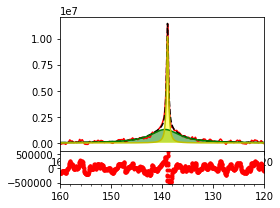

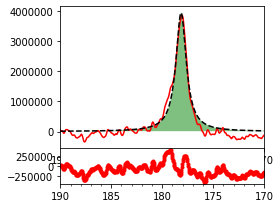

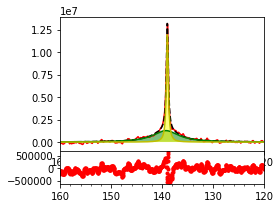

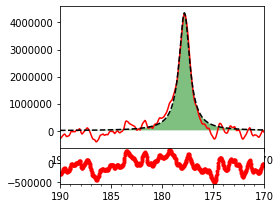

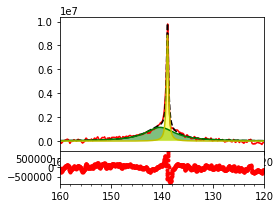

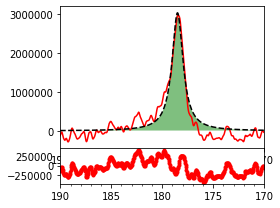

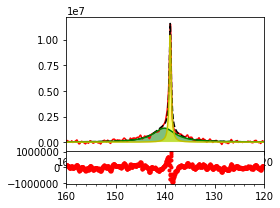

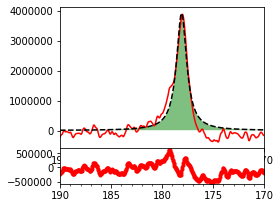

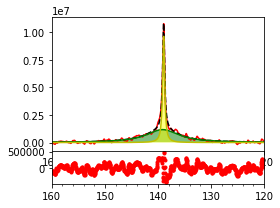

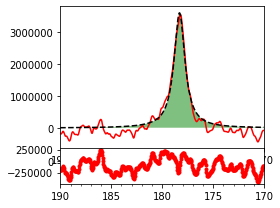

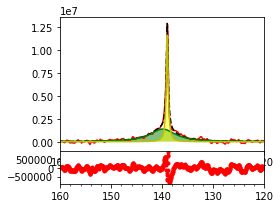

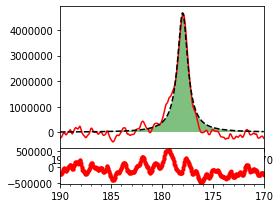

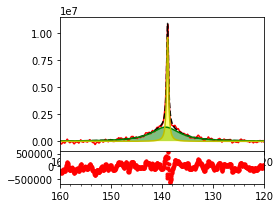

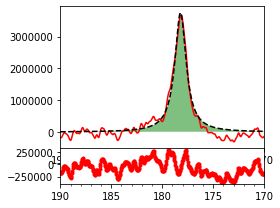

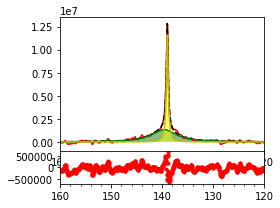

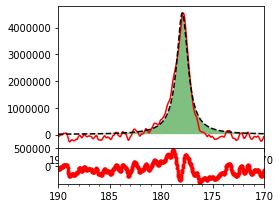

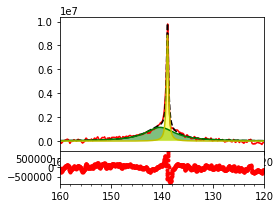

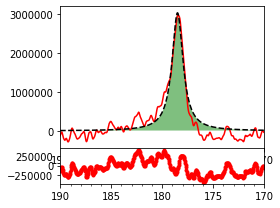

In [24]:
ddir2='/Users/yunyao/Dropbox/Data_charge_distribution/CoSeC60_MIX'
filename='test.ft'
df=pd.DataFrame(columns=['data', 'amp_1', 'amp_err_1','cen_1', 'cen_err_1', 'wid_1', 'wid_err_1','amp_2', 'amp_err_2','cen_2', 'cen_err_2', 'wid_2', 'wid_err_2','amp_3', 'amp_err_3','cen_3', 'cen_err_3', 'wid_3', 'wid_err_3'])
i=0
for dirpath, dirnames, filenames in os.walk(ddir2):
    #print(dirnames)
    for item in dirnames:
        if len(item.split('_'))>=3 and item.split('_')[-3]=='C':
            print(item)
            dirna = os.path.join(ddir2, item, filename)
            fit_re=Lorentz_fit(dirna, 160, 120, [1.2e7, 2, 144, 0.4e7, 5, 140 ], 2)
            fit_re_2=Lorentz_fit(dirna, 190, 170, [1.2e7, 2, 179 ], 1)
            df=df.append({'data': item, 'amp_1': fit_re[0], 'amp_err_1': fit_re[6], \
                          'cen_1': fit_re[1], 'cen_err_1': fit_re[7], \
                          'wid_1': fit_re[2], 'wid_err_1': fit_re[8],  \
                          'amp_2': fit_re[3], 'amp_err_2': fit_re[9], \
                          'cen_2': fit_re[4], 'cen_err_2': fit_re[10], \
                          'wid_2': fit_re[5], 'wid_err_2': fit_re[11],  \
                          'amp_3': fit_re_2[0], 'amp_err_3': fit_re_2[3], \
                          'cen_3': fit_re_2[1], 'cen_err_3': fit_re_2[4], \
                          'wid_3': fit_re_2[2], 'wid_err_3': fit_re_2[5]  \
                         },ignore_index=True )


In [25]:
df

,data,amp_1,amp_err_1,cen_1,cen_err_1,wid_1,wid_err_1,amp_2,amp_err_2,cen_2,cen_err_2,wid_2,wid_err_2,amp_3,amp_err_3,cen_3,cen_err_3,wid_3,wid_err_3
0,0311_C60CoSemix_C_1pda_m10C,1.291784e+06,25676.207647,139.443483,0.045279,3.458300,0.076216,1.020450e+07,64090.551563,138.946720,0.001388,0.222780,0.002502,3.943011e+06,52165.109213,178.149245,0.008168,0.617482,0.011557
1,0309_C60CoSemix_C_1pda_15C,1.276495e+06,31724.310772,139.272041,0.044877,3.049652,0.081137,1.198940e+07,68710.757622,138.982950,0.001259,0.223009,0.002356,4.356158e+06,51629.204680,177.818220,0.007442,0.628047,0.010532
2,0313_C60CoSemix_C_1pda_m35C,1.149467e+06,25308.953108,140.405692,0.073314,3.587250,0.091231,8.858413e+06,77039.226437,138.952878,0.002013,0.231973,0.003482,3.043753e+06,54964.855695,178.499096,0.011760,0.651308,0.016642
3,0310_C60CoSemix_C_1pda_0C,1.366470e+06,32797.087747,140.203664,0.061989,2.749839,0.071565,1.043494e+07,83687.308195,138.992504,0.001829,0.229585,0.003323,3.911000e+06,68158.605352,178.095318,0.010542,0.605027,0.014917
4,0312_C60CoSemix_C_1pda_m20C,1.173759e+06,23364.565949,139.128936,0.046958,3.755876,0.084256,9.673232e+06,59792.902032,138.932036,0.001391,0.226741,0.002492,3.601117e+06,51579.783033,178.304805,0.009259,0.646532,0.013102
5,0309_C60CoSemix_C_1pda_5C,1.381118e+06,33926.197916,139.884951,0.056908,2.982446,0.078618,1.161529e+07,82490.391225,138.998568,0.001580,0.224272,0.002877,4.668293e+06,60405.639248,177.992688,0.007866,0.607991,0.011130
6,0312_C60CoSemix_C_1pda_m15C,1.312970e+06,27201.436227,139.352489,0.045905,3.406461,0.078677,9.651868e+06,68785.708790,138.937656,0.001512,0.213868,0.002717,3.744075e+06,44942.559065,178.204927,0.008088,0.673897,0.011446
7,0309_C60CoSemix_C_1pda_10C,1.330560e+06,31829.391950,139.615133,0.047388,2.921110,0.074005,1.157741e+07,71069.449251,138.991279,0.001352,0.222938,0.002511,4.551437e+06,55488.589757,177.935537,0.008060,0.661255,0.011407
8,0313_C60CoSemix_C_1pda_m30C,1.149467e+06,25308.953108,140.405692,0.073314,3.587250,0.091231,8.858413e+06,77039.226437,138.952878,0.002013,0.231973,0.003482,3.043753e+06,54964.855695,178.499096,0.011760,0.651308,0.016642


In [26]:
df1=df

In [27]:
df1['temp']=[-10, 15, -35, 0 , -20, 5, -15, 10, -30]

In [28]:
df1.sort_values(by='temp')

,data,amp_1,amp_err_1,cen_1,cen_err_1,wid_1,wid_err_1,amp_2,amp_err_2,cen_2,cen_err_2,wid_2,wid_err_2,amp_3,amp_err_3,cen_3,cen_err_3,wid_3,wid_err_3,temp
2,0313_C60CoSemix_C_1pda_m35C,1.149467e+06,25308.953108,140.405692,0.073314,3.587250,0.091231,8.858413e+06,77039.226437,138.952878,0.002013,0.231973,0.003482,3.043753e+06,54964.855695,178.499096,0.011760,0.651308,0.016642,-35
8,0313_C60CoSemix_C_1pda_m30C,1.149467e+06,25308.953108,140.405692,0.073314,3.587250,0.091231,8.858413e+06,77039.226437,138.952878,0.002013,0.231973,0.003482,3.043753e+06,54964.855695,178.499096,0.011760,0.651308,0.016642,-30
4,0312_C60CoSemix_C_1pda_m20C,1.173759e+06,23364.565949,139.128936,0.046958,3.755876,0.084256,9.673232e+06,59792.902032,138.932036,0.001391,0.226741,0.002492,3.601117e+06,51579.783033,178.304805,0.009259,0.646532,0.013102,-20
6,0312_C60CoSemix_C_1pda_m15C,1.312970e+06,27201.436227,139.352489,0.045905,3.406461,0.078677,9.651868e+06,68785.708790,138.937656,0.001512,0.213868,0.002717,3.744075e+06,44942.559065,178.204927,0.008088,0.673897,0.011446,-15
0,0311_C60CoSemix_C_1pda_m10C,1.291784e+06,25676.207647,139.443483,0.045279,3.458300,0.076216,1.020450e+07,64090.551563,138.946720,0.001388,0.222780,0.002502,3.943011e+06,52165.109213,178.149245,0.008168,0.617482,0.011557,-10
3,0310_C60CoSemix_C_1pda_0C,1.366470e+06,32797.087747,140.203664,0.061989,2.749839,0.071565,1.043494e+07,83687.308195,138.992504,0.001829,0.229585,0.003323,3.911000e+06,68158.605352,178.095318,0.010542,0.605027,0.014917,0
5,0309_C60CoSemix_C_1pda_5C,1.381118e+06,33926.197916,139.884951,0.056908,2.982446,0.078618,1.161529e+07,82490.391225,138.998568,0.001580,0.224272,0.002877,4.668293e+06,60405.639248,177.992688,0.007866,0.607991,0.011130,5
7,0309_C60CoSemix_C_1pda_10C,1.330560e+06,31829.391950,139.615133,0.047388,2.921110,0.074005,1.157741e+07,71069.449251,138.991279,0.001352,0.222938,0.002511,4.551437e+06,55488.589757,177.935537,0.008060,0.661255,0.011407,10
1,0309_C60CoSemix_C_1pda_15C,1.276495e+06,31724.310772,139.272041,0.044877,3.049652,0.081137,1.198940e+07,68710.757622,138.982950,0.001259,0.223009,0.002356,4.356158e+06,51629.204680,177.818220,0.007442,0.628047,0.010532,15


In [31]:
df1['cen_1']=df1['cen_1']+4.1
df1['cen_2']=df1['cen_2']+4.1
df1['cen_3']=df1['cen_3']+4.1

In [32]:
df1

,data,amp_1,amp_err_1,cen_1,cen_err_1,wid_1,wid_err_1,amp_2,amp_err_2,cen_2,cen_err_2,wid_2,wid_err_2,amp_3,amp_err_3,cen_3,cen_err_3,wid_3,wid_err_3,temp
0,0311_C60CoSemix_C_1pda_m10C,1.291784e+06,25676.207647,147.643483,0.045279,3.458300,0.076216,1.020450e+07,64090.551563,143.046720,0.001388,0.222780,0.002502,3.943011e+06,52165.109213,182.249245,0.008168,0.617482,0.011557,-10
1,0309_C60CoSemix_C_1pda_15C,1.276495e+06,31724.310772,147.472041,0.044877,3.049652,0.081137,1.198940e+07,68710.757622,143.082950,0.001259,0.223009,0.002356,4.356158e+06,51629.204680,181.918220,0.007442,0.628047,0.010532,15
2,0313_C60CoSemix_C_1pda_m35C,1.149467e+06,25308.953108,148.605692,0.073314,3.587250,0.091231,8.858413e+06,77039.226437,143.052878,0.002013,0.231973,0.003482,3.043753e+06,54964.855695,182.599096,0.011760,0.651308,0.016642,-35
3,0310_C60CoSemix_C_1pda_0C,1.366470e+06,32797.087747,148.403664,0.061989,2.749839,0.071565,1.043494e+07,83687.308195,143.092504,0.001829,0.229585,0.003323,3.911000e+06,68158.605352,182.195318,0.010542,0.605027,0.014917,0
4,0312_C60CoSemix_C_1pda_m20C,1.173759e+06,23364.565949,147.328936,0.046958,3.755876,0.084256,9.673232e+06,59792.902032,143.032036,0.001391,0.226741,0.002492,3.601117e+06,51579.783033,182.404805,0.009259,0.646532,0.013102,-20
5,0309_C60CoSemix_C_1pda_5C,1.381118e+06,33926.197916,148.084951,0.056908,2.982446,0.078618,1.161529e+07,82490.391225,143.098568,0.001580,0.224272,0.002877,4.668293e+06,60405.639248,182.092688,0.007866,0.607991,0.011130,5
6,0312_C60CoSemix_C_1pda_m15C,1.312970e+06,27201.436227,147.552489,0.045905,3.406461,0.078677,9.651868e+06,68785.708790,143.037656,0.001512,0.213868,0.002717,3.744075e+06,44942.559065,182.304927,0.008088,0.673897,0.011446,-15
7,0309_C60CoSemix_C_1pda_10C,1.330560e+06,31829.391950,147.815133,0.047388,2.921110,0.074005,1.157741e+07,71069.449251,143.091279,0.001352,0.222938,0.002511,4.551437e+06,55488.589757,182.035537,0.008060,0.661255,0.011407,10
8,0313_C60CoSemix_C_1pda_m30C,1.149467e+06,25308.953108,148.605692,0.073314,3.587250,0.091231,8.858413e+06,77039.226437,143.052878,0.002013,0.231973,0.003482,3.043753e+06,54964.855695,182.599096,0.011760,0.651308,0.016642,-30


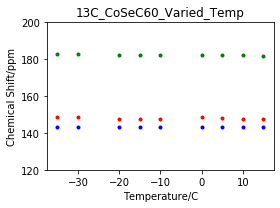

In [46]:
fig = plt.figure(figsize=(4,3))
gs = gridspec.GridSpec(1,1 )
ax1 = fig.add_subplot(gs[0])
#ax2  =fig.add_subplot(gs[1])
gs.update(hspace=0)

#ax1.plot(ppm2, data2, "r-")
#ax1.plot(ppm2, _2Lorentzian(ppm2, *popt_2lorentz), 'k--')

ax1.plot(df1['temp'], df1['cen_1'], 'ro', markersize=3 )
ax1.plot(df1['temp'], df1['cen_2'], 'bo', markersize=3 )
ax1.plot(df1['temp'], df1['cen_3'], 'go', markersize=3 )

# ax2.xaxis.set_major_locator(ticker.AutoLocator())
# ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())

ax1.set_ylim(120, 200)
ax1.set_xlabel('Temperature/C')
ax1.set_ylabel('Chemical Shift/ppm')
ax1.set_title('13C_CoSeC60_Varied_Temp')
fig.tight_layout()
fig.savefig("13C_CoSeC60_temp.png", format="png",dpi=1000)


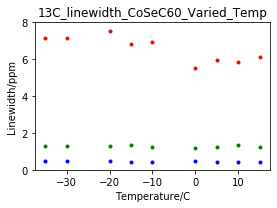

In [49]:
fig = plt.figure(figsize=(4,3))
gs = gridspec.GridSpec(1,1 )
ax1 = fig.add_subplot(gs[0])
#ax2  =fig.add_subplot(gs[1])
gs.update(hspace=0)

#ax1.plot(ppm2, data2, "r-")
#ax1.plot(ppm2, _2Lorentzian(ppm2, *popt_2lorentz), 'k--')

ax1.plot(df1['temp'], df1['wid_1']*2, 'ro', markersize=3 )
ax1.plot(df1['temp'], df1['wid_2']*2, 'bo', markersize=3 )
ax1.plot(df1['temp'], df1['wid_3']*2, 'go', markersize=3 )

# ax2.xaxis.set_major_locator(ticker.AutoLocator())
# ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())

ax1.set_ylim(0, 8)
ax1.set_xlabel('Temperature/C')
ax1.set_ylabel('Linewidth/ppm')
ax1.set_title('13C_linewidth_CoSeC60_Varied_Temp')
fig.tight_layout()
fig.savefig("13C_linewidth_CoSeC60_Varied_Temp.png", format="png",dpi=1000)
